In [49]:
import csv
import numpy as np
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering

from datetime import datetime, timedelta

In [50]:
class Request:
    
    def __init__(self, ID):
        # ID_Transportu
        # KrajZal KodZal MiejsceZal AdresZal
        # KrajRoz KodRoz MiejsceRoz AdresRoz
        # IloscPelnychPalet IloscPaletKoncowych LacznaWaga Odleglosc
        # Typ TypTransportu
        # Cena Waluta
        # DataWysylki GodzinaWysylki DataDostarczenia GodzinaDostarczenia
        self.ID = ID
        # load place data
        self.LCountry = ''
        self.LCode = ''
        self.LPlace = ''
        self.LAddress = ''
        # unload place data
        self.UCountry = ''
        self.UCode = ''
        self.UPlace = ''
        self.UAddress = ''
        # 
        self.num_pal = 0
        self.num_pal_full = 0
        self.weight = 0
        self.distance = 0
        # 
        self.type = None
        self.transport = None
        # 
        self.price = 0
        self.currency = ''
        #
        self.sent_date = ''
        #self.sent_time = ''
        self.receive_date = ''
        #self.receive_time = ''
        
        self.orgn = None
        self.dest = None

In [51]:
class Place:
    
    def __init__(self, ID):
        self.ID = ID
        self.country = ''
        self.string = ''
        self.type = ''
        self.lat = 0
        self.lng = 0

In [52]:
requests = []

with open('TMSv3.csv', 'r', encoding='ISO-8859-1') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='.')
    for data in reader:
        req = Request(int(data[0]))
        #
        req.LCountry = data[1] if data[1] != 'NULL' else None
        req.LCode = data[2].replace(' ', '') if data[2] != 'NULL' else None
        req.LPlace = data[3] if data[3] != 'NULL' else None
        req.LAddress = data[4] if data[4] != 'NULL' else None
        # unload place data
        req.UCountry = data[5] if data[5] != 'NULL' else None
        req.UCode = data[6].replace(' ', '') if data[6] != 'NULL' else None
        req.UPlace = data[7] if data[7] != 'NULL' else None
        req.UAddress = data[8] if data[8] != 'NULL' else None
        # 
        req.num_pal = int(data[9])
        req.num_pal_full = int(data[10])
        req.weight = float(data[11]) if data[11] != 'NULL' else 0.0
        req.distance = float(data[12]) if data[12] != 'NULL' else 0.0
        # 
        if data[13] == 'Duzy':
            req.type = 'L'
        elif data[13] == 'sredni':
            req.type = 'M'
        elif data[13] == 'Maly':
            req.type = 'S'
        else:
            print(data[13])
        req.transport = data[14] if data[14] != 'NULL' else None
        # 
        req.price = float(data[15]) if data[15] != 'NULL' else None
        req.currency = data[16]
        #
        if data[17] != 'NULL':
            req.sent_date = datetime(int(data[17][6:]), int(data[17][3:5]), int(data[17][:2]),
                                     int(data[18][:2]), int(data[18][3:5]))
        else:
            req.sent_date = None
        if data[19] != 'NULL':
            req.receive_date = datetime(int(data[19][6:]), int(data[19][3:5]), int(data[19][:2]),
                                        int(data[20][:2]), int(data[20][3:5]))
        else:
            req.receive_date = None
        
        requests.append(req)

In [53]:
len(requests)

14440

In [54]:
# get requests with complete data
crequests = []
names = []
for r in requests:
    if r.LCountry is not None and \
       r.LCode is not None and \
       r.UCountry is not None and \
       r.UCode is not None and \
       r.transport is not None:
        if r.weight == 'NULL':
            r.weight = 0.0
        crequests.append(r)
        L_name = r.LCountry + ' ' + r.LCode
        U_name = r.UCountry + ' ' + r.UCode
        #print L_place, U_place
        if L_name not in names:
            names.append(L_name)
        if U_name not in names:
            names.append(U_name)
            
len(crequests), len(names)

(12334, 897)

In [55]:
places = []
with open('places.csv', 'r') as pfile:
    preader = csv.reader(pfile, delimiter=';', quotechar='.')
    for data in preader:
        place = Place(int(data[0]))
        place.country = data[1]
        place.string = data[2]
        place.type = data[3]
        place.lat = float(data[4])
        place.lng = float(data[5])
        places.append(place)

In [56]:
len(places)

897

In [57]:
def get_str(string, xs):
    for x in xs:
        if x.string == string:
            return x
    return None

In [58]:
def get(ID, xs):
    for x in xs:
        if x.ID == ID:
            return x
    return None

In [59]:
for req in crequests:
    orgn = get_str(req.LCountry + ' ' + req.LCode, places)
    dest = get_str(req.UCountry + ' ' + req.UCode, places)
    req.orgn, req.dest = orgn, dest

In [60]:
req = crequests[10]
req.weight, req.dest.lat, req.dest.lng, req.sent_date

(2923.4, 49.4175921, 11.124471, datetime.datetime(2019, 8, 30, 8, 30))

In [61]:
set([r.transport for r in crequests])

{'FTL', 'Inne', 'Kurier', 'LTL'}

In [62]:
transport = {}
for r in crequests:
    if r.transport in transport:
        transport[r.transport].append(r)
    else:
        transport[r.transport] = [r]

In [63]:
ftls, ltls = transport['FTL'], transport['LTL']
for t in transport:
    print(t, len(transport[t]))
print(len(ftls), len(ltls))

FTL 10775
LTL 1545
Inne 12
Kurier 2
10775 1545


In [64]:
# LTL
set([r.orgn.ID for r in ftls])

{1, 3, 44, 149}

In [65]:
orgns, dests = {}, {}
for r in ltls:
    if r.orgn.ID in orgns:
        orgns[r.orgn.ID].append(r)
    else:
        orgns[r.orgn.ID] = [r]
    if r.dest.ID in dests:
        dests[r.dest.ID].append(r)
    else:
        dests[r.dest.ID] = [r]
        
print(len(set(orgns)), len(set(dests)))
print()
for ID in orgns:
     print(ID, len(orgns[ID]))

4 355

3 778
1 417
44 46
149 304


In [66]:
#kmeans = KMeans(n_clusters=3).fit(ltls)

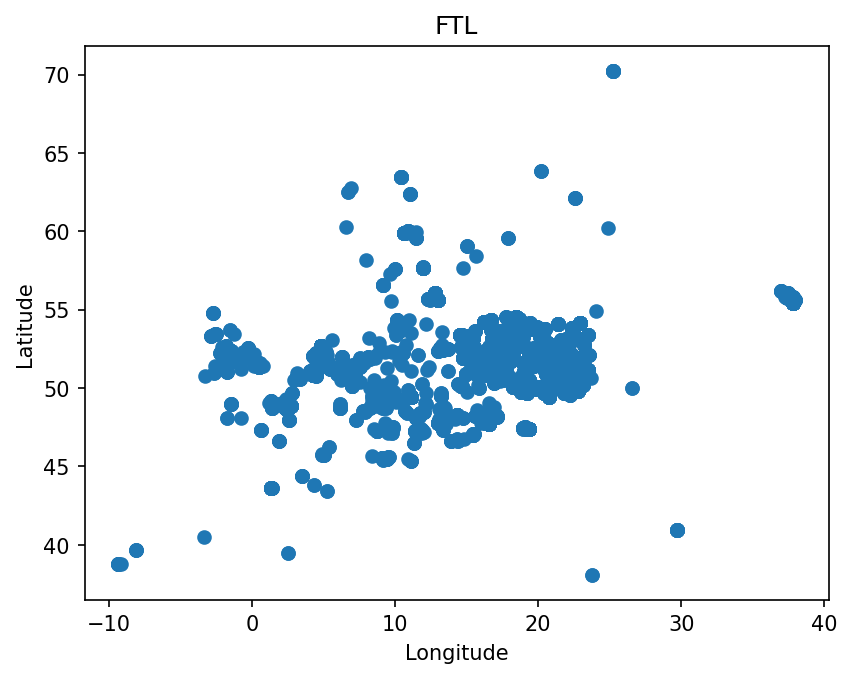

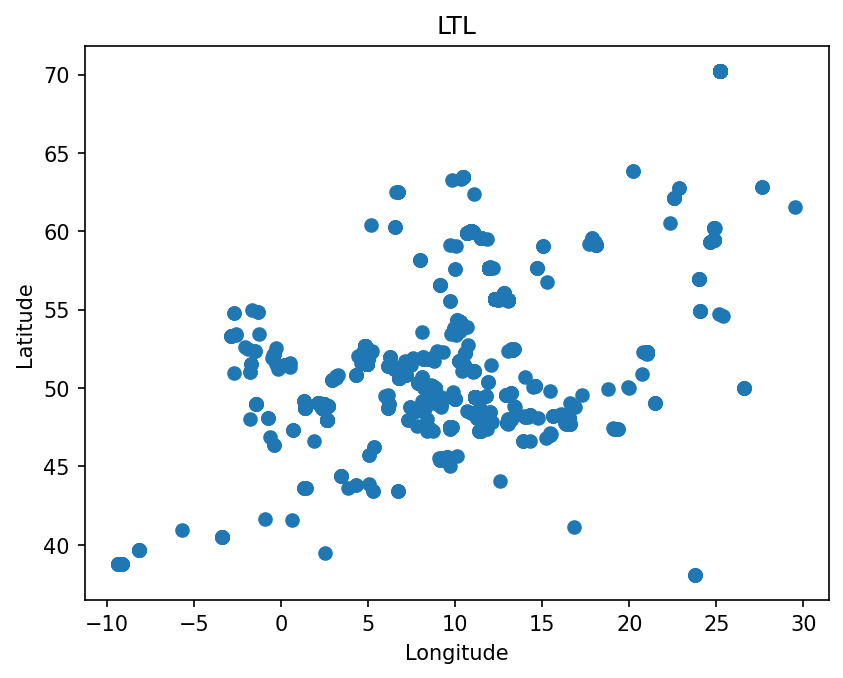

In [67]:
def plot_map(reqs, title=''):
    lats = [r.dest.lat for r in reqs]
    lngs = [r.dest.lng for r in reqs]
    plt.figure(dpi=150)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.scatter(lngs, lats)
    plt.show()
plot_map(ftls, 'FTL')
plot_map(ltls, 'LTL')

Origins: ['PL 27-200', 'PL 30-733', 'PL 30-740', 'PL 31-983']
[1, 1]
[0, 0]
[11, 2]
[53, 16]
[47, 16]
[52, 15]
[37, 22]
[40, 9]
[44, 30]
[54, 21]
[70, 15]
[29, 20]
[53, 11]
[43, 11]
[42, 52]
[33, 18]
[46, 11]
[54, 22]
[19, 5]
[3, 2]
[45, 7]
[35, 10]
[40, 11]
[45, 8]
[38, 13]
[55, 8]
[44, 17]
[31, 22]
[64, 22]


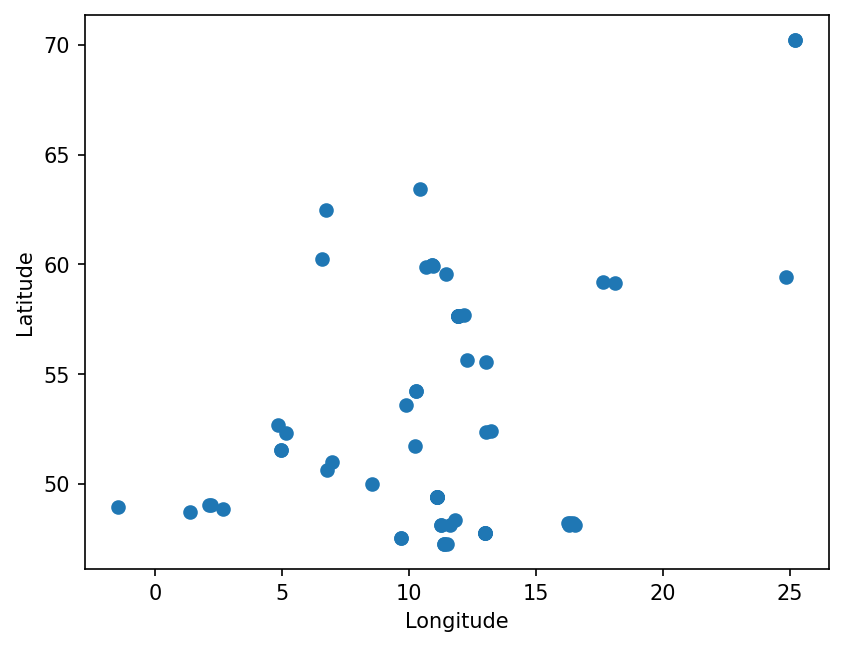

In [68]:
def split_reqs(reqs, step=7):
    start = min([r.sent_date for r in reqs])
    finish = max([r.sent_date for r in reqs])
    days = (finish - start).days
    bins = days // step
    grid = sorted([finish - timedelta(step) * b for b in range(bins)])
    #print grid
    orgns = sorted(list(set([r.orgn for r in reqs])), key=lambda p: p.string)
    print('Origins:', [orgn.string for orgn in orgns])
    subsets = []
    for g in range(len(grid)):
        subset = [[] for _ in orgns]
        for r in reqs:
            for i in range(len(orgns)):
                if g == 0:
                    if r.orgn is orgns[i] and r.sent_date <= grid[g]:
                        subset[i].append(r)
                else:
                    if r.orgn is orgns[i] and r.sent_date > grid[g - 1] and r.sent_date <= grid[g]:
                        subset[i].append(r)
        subsets.append(subset)
    return subsets, orgns

ss = split_reqs(ltls, 7)
gs = []
for s in ss[0]:
    krk, sta = [], []
    krk.extend(s[1])
    krk.extend(s[2])
    krk.extend(s[3])
    sta.extend(s[0])
    gs.append([krk, sta])

# for s in ss[0]:
#     print([len(g) for g in s])
    
for s in gs:
    print([len(g) for g in s])
    
plot_map(gs[-1][0])
# for r in ss[3][1]:
#     print(r.sent_date, r.receive_date)

In [69]:
# PL 30-740 Walstead - CLK
# PL 30-733 Walstead - Podgorze - P1
# PL 31-983 Walstead - Nowa Huta - P2
# PL 27-200 Walstead Starachowice - P4

In [70]:
# gs

In [71]:
def cluster_KMeans(reqs, k=2, visual=True):
    rs = [[r.dest.lat, r.dest.lng] for r in reqs]
    kmeans = KMeans(n_clusters=k).fit(rs)

    clusters = [[] for _ in range(kmeans.n_clusters)]
    tws = [0.0 for _ in range(kmeans.n_clusters)]
    for i in range(len(rs)):
        clusters[kmeans.labels_[i]].append(rs[i])
        tws[kmeans.labels_[i]] += 0.001 * reqs[i].weight
        reqs[i].cluster = kmeans.labels_[i]

    if visual:
        clusters = np.array([np.array(cluster) for cluster in clusters])
        plt.figure(dpi=150)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')

        for cluster in clusters:
            plt.scatter(cluster[:, 1], cluster[:, 0])
        plt.show()
    
    return tws


def cluster_MiniBatchKMeans(reqs, k=2, visual=True):
    rs = [[r.dest.lat, r.dest.lng] for r in reqs]
    kmeans = MiniBatchKMeans(n_clusters=k).fit(rs)

    clusters = [[] for _ in range(kmeans.n_clusters)]
    tws = [0.0 for _ in range(kmeans.n_clusters)]
    for i in range(len(rs)):
        clusters[kmeans.labels_[i]].append(rs[i])
        tws[kmeans.labels_[i]] += 0.001 * reqs[i].weight
        reqs[i].cluster = kmeans.labels_[i]
    
    if visual:
        clusters = np.array([np.array(cluster) for cluster in clusters])
        plt.figure(dpi=150)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')

        for cluster in clusters:
            plt.scatter(cluster[:, 1], cluster[:, 0])
        plt.show()
    
    return tws


def cluster_Birch(reqs, k=2, visual=True):
    rs = [[r.dest.lat, r.dest.lng] for r in reqs]
    kmeans = Birch(n_clusters=k).fit(rs)

    clusters = [[] for _ in range(kmeans.n_clusters)]
    tws = [0.0 for _ in range(kmeans.n_clusters)]
    for i in range(len(rs)):
        clusters[kmeans.labels_[i]].append(rs[i])
        tws[kmeans.labels_[i]] += 0.001 * reqs[i].weight
        reqs[i].cluster = kmeans.labels_[i]
    
    if visual:
        clusters = np.array([np.array(cluster) for cluster in clusters])
        plt.figure(dpi=150)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        for cluster in clusters:
            plt.scatter(cluster[:, 1], cluster[:, 0])
        plt.show()

    return tws


def cluster_AgglomerativeClustering(reqs, k=2, visual=True):
    rs = [[r.dest.lat, r.dest.lng] for r in reqs]
    kmeans = AgglomerativeClustering(n_clusters=k).fit(rs)

    clusters = [[] for _ in range(kmeans.n_clusters)]
    tws = [0.0 for _ in range(kmeans.n_clusters)]
    for i in range(len(rs)):
        clusters[kmeans.labels_[i]].append(rs[i])
        tws[kmeans.labels_[i]] += 0.001 * reqs[i].weight
        reqs[i].cluster = kmeans.labels_[i]
    
    if visual:
        clusters = np.array([np.array(cluster) for cluster in clusters])
        plt.figure(dpi=150)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        for cluster in clusters:
            plt.scatter(cluster[:, 1], cluster[:, 0])
        plt.show()
        
    return tws


64


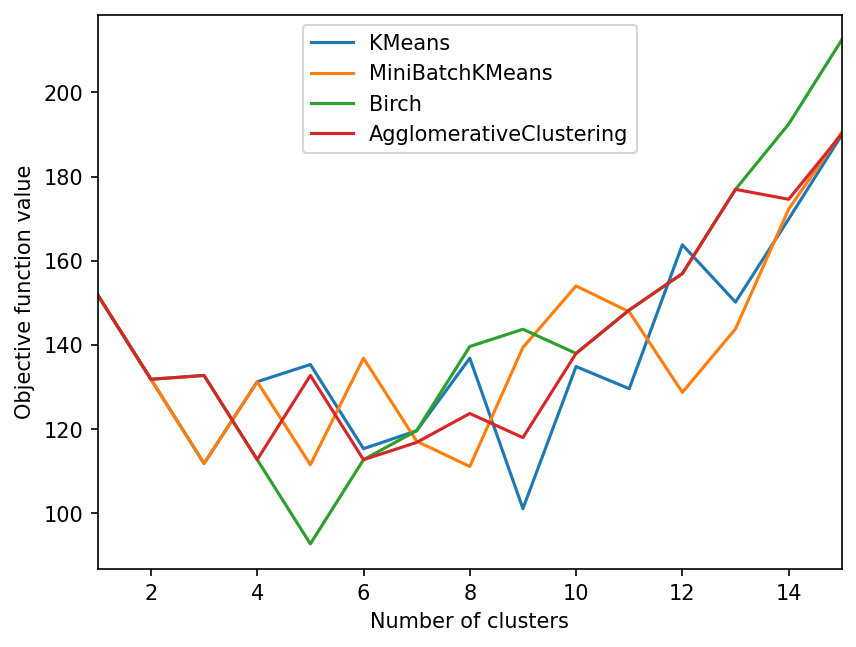

In [72]:
def objectives(reqs, k, q=20):
    
    def f(xs):
        return sum([abs(x - q) for x in xs])
    
    return [f(cluster_KMeans(reqs, k, False)),
            f(cluster_MiniBatchKMeans(reqs, k, False)),
            f(cluster_Birch(reqs, k, False)),
            f(cluster_AgglomerativeClustering(reqs, k, False))]

reqs = gs[-1][0]
#reqs = ss[14][3]
print(len(reqs))
ks = range(1, 16)
fs = np.array([objectives(reqs, k) for k in ks])

plt.figure(dpi=150)
plt.xlim(1, 15)
plt.xlabel('Number of clusters')
plt.ylabel('Objective function value')
plt.plot(ks, fs[:, 0], label='KMeans')
plt.plot(ks, fs[:, 1], label='MiniBatchKMeans')
plt.plot(ks, fs[:, 2], label='Birch')
plt.plot(ks, fs[:, 3], label='AgglomerativeClustering')
plt.legend(loc='upper center')
plt.show()

In [73]:
# cluster_Birch(reqs, k=2, visual=True)
# cluster_AgglomerativeClustering(reqs, k=9, visual=True)
# cluster_MiniBatchKMeans(reqs, k=6, visual=True)

In [74]:
# def reqs_to_file(reqs, fname):
#     f = open(fname, 'w')
#     f.write('ID;LCountry;LCode;UCountry;UCode;num_pal;num_pal_full;weight;' + \
#             'distance;price;currency;sent_date;receive_date;cluster\n')    
    
#     for r in reqs:
#         f.write(str(r.ID) + ';' + \
#                 r.LCountry + ';' + r.LCode + ';' + \
#                 r.UCountry + ';' + r.UCode + ';' + \
#                 str(r.num_pal) + ';' + str(r.num_pal_full) + ';' + \
#                 str(r.weight) + ';' + str(r.distance) + ';' + \
#                 str(r.price) + ';' + r.currency + ';' + \
#                 str(r.sent_date) + ';' + str(r.receive_date) + ';' + \
#                 str(r.cluster) + '\n')
#     f.close()

# reqs_to_file(reqs, 'reqs.csv')

In [75]:
from collections import namedtuple
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

In [76]:
class Customers():
    """
        A class that holds customers information
    """

    def __init__(self, reqs):
        
        num_stops = len(reqs)
        self.number = num_stops #: The number of customers and depots

        # The number of seconds needed to 'unload' 1 unit of goods.
        self.service_time_per_dem = 1 # sec
        #
        self.time_horizon = 2 * 24 * 3600  # sec
        
        # The 'name' of the stop, indexed from 0 (depot), 1 to num_stops
        stops = np.array(range(0, num_stops + 1))

        # Set demands
        demands = [0] # 0 demand for depot
        demands.extend([int(r.weight) for r in reqs])
        
        # Set locations
        orgn = reqs[0].orgn # depot location
        lats, lngs = [orgn.lat], [orgn.lng]
        lats.extend([r.dest.lat for r in reqs])
        lngs.extend([r.dest.lng for r in reqs])
        
        # Set time windows
        zero_time = min([r.sent_date for r in reqs])
        start_times, stop_times = [None], [None]
        for r in reqs:
            ub = r.receive_date - zero_time
            start_times.append(0)
            stop_times.append(int(ub.days * 24 * 3600 + ub.seconds))
        
        # A named tuple for the customer
        Customer = namedtuple(
            'Customer',
            [
                'index',  # the index of the stop
                'demand',  # the demand for the stop
                'lat',  # the latitude of the stop
                'lon',  # the longitude of the stop
                'tw_open',  # timedelta window open
                'tw_close' # timedelta window cls
            ])

        self.customers = [
            Customer(idx, dem, lat, lon, tw_open, tw_close)
            for idx, dem, lat, lon, tw_open, tw_close in zip(
                stops, demands, lats, lngs, start_times, stop_times)
        ]

    def set_manager(self, manager):
        self.manager = manager

    def make_distance_mat(self, method='haversine'):
        """
        Return a distance matrix and make it a member of Customer, using the
        method given in the call. Currently only Haversine (GC distance) is
        implemented, but Manhattan, or using a maps API could be added here.
        Raises an AssertionError for all other methods.
        Args: method (Optional[str]): method of distance calculation to use. The
        Haversine formula is the only method implemented.
        Returns:
            Numpy array of node to node distances.
        Examples:
            >>> dist_mat = customers.make_distance_mat(method='haversine')
            >>> dist_mat = customers.make_distance_mat(method='manhattan')
            AssertionError
        """
        self.distmat = np.zeros((self.number, self.number))
        methods = {'haversine': self._haversine}
        assert (method in methods)
        for frm_idx in range(self.number):
            for to_idx in range(self.number):
                if frm_idx != to_idx:
                    frm_c = self.customers[frm_idx]
                    to_c = self.customers[to_idx]
                    self.distmat[frm_idx, to_idx] = self._haversine(
                        frm_c.lon, frm_c.lat, to_c.lon, to_c.lat)
        return (self.distmat)

    def _haversine(self, lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance between two points
        on the earth specified in decimal degrees of latitude and longitude.
        https://en.wikipedia.org/wiki/Haversine_formula
        Args:
            lon1: longitude of pt 1,
            lat1: latitude of pt 1,
            lon2: longitude of pt 2,
            lat2: latitude of pt 2
        Returns:
            the distace in km between pt1 and pt2
        """
        # convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        # haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = (np.sin(dlat / 2)**2 +
             np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2)
        c = 2 * np.arcsin(np.sqrt(a))
        # 6367 km is the radius of the Earth
        km = 6367 * c
        return km

    def get_total_demand(self):
        """
        Return the total demand of all customers
        """
        return (sum([c.demand for c in self.customers]))

    def return_dist_callback(self, **kwargs):
        """
        Return a callback function for the distance matrix.
        Args: **kwargs: Arbitrary keyword arguments passed on to
        make_distance_mat()
        Returns:
            function: dist_return(a,b) A function that takes the 'from' node
                index and the 'to' node index and returns the distance in km.
        """
        self.make_distance_mat(**kwargs)
        def dist_return(from_index, to_index):
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = self.manager.IndexToNode(from_index)
            to_node = self.manager.IndexToNode(to_index)
            return (self.distmat[from_node][to_node])
        return dist_return

    def return_dem_callback(self):
        """
        Return a callback function that gives the demands.
        Returns:
            function: dem_return(a) A function that takes the 'from' node
                index and returns the distance in km.
        """
        def dem_return(from_index):
            # Convert from routing variable Index to distance matrix NodeIndex.
            from_node = self.manager.IndexToNode(from_index)
            return (self.customers[from_node].demand)
        return dem_return

    def make_service_time_call_callback(self):
        """
        Return a callback function that provides the time spent servicing the
        customer.  Here is it proportional to the demand given by
        self.service_time_per_dem, default 300 seconds per unit demand.
        Returns:
            function [dem_return(a, b)]: A function that takes the from/a node
                index and the to/b node index and returns the service time at a
        """
        def service_time_return(a, b):
            return (self.customers[a].demand * self.service_time_per_dem)
        return service_time_return

    def make_transit_time_callback(self, speed_kmph=60):
        """
        Creates a callback function for transit time. Assuming an average
        speed of speed_kmph
        Args:
            speed_kmph: the average speed in km/h
        Returns:
            function [transit_time_return(a, b)]: A function that takes the
                from/a node index and the to/b node index and returns the
                transit time from a to b.
        """
        def transit_time_return(a, b):
            return (self.distmat[a][b] / (speed_kmph * 1.0 / 60**2))
        return transit_time_return


In [77]:
class Vehicles():
    """
    A Class to create and hold vehicle information.
    The Vehicles in a CVRPTW problem service the customers and belong to a
    depot. The class Vehicles creates a list of named tuples describing the
    Vehicles. The main characteristics are the vehicle capacity, fixed cost,
    and cost per km. The fixed cost of using a certain type of vehicles can be
    higher or lower than others. If a vehicle is used, i.e. this vehicle serves
    at least one node, then this cost is added to the objective function.
    Note:
        If numpy arrays are given for capacity and cost, then they must be of
        the same length, and the number of vehicles are inferred from them.
        If scalars are given, the fleet is homogeneous, and the number of
        vehicles is determined by number.
    Args:
    capacity (scalar or numpy array): The integer capacity of demand
    units.
    cost (scalar or numpy array): The fixed cost of the vehicle.
    number (Optional [int]): The number of vehicles in a homogeneous fleet.
    """

    def __init__(self, capacity=100, cost=100, number=None):

        Vehicle = namedtuple('Vehicle', ['index', 'capacity', 'cost'])

        if number is None:
            self.number = np.size(capacity)
        else:
            self.number = number
        idxs = np.array(range(0, self.number))

        if np.isscalar(capacity):
            capacities = capacity * np.ones_like(idxs)
        elif np.size(capacity) != self.number:
            print('capacity is neither scalar, nor the same size as num!')
        else:
            capacities = capacity

        if np.isscalar(cost):
            costs = cost * np.ones_like(idxs)
        elif np.size(cost) != self.number:
            print(np.size(cost))
            print('cost is neither scalar, nor the same size as num!')
        else:
            costs = cost

        self.vehicles = [
            Vehicle(idx, capacity, cost)
            for idx, capacity, cost in zip(idxs, capacities, costs)
        ]

    def get_total_capacity(self):
        return (sum([c.capacity for c in self.vehicles]))

    def return_starting_callback(self, customers):
        # create a different starting and finishing depot for each vehicle
        self.starts = [0 for o in range(self.number)]
        self.ends = [0 for o in range(self.number)]
        def start_return(v):
            return (self.starts[v])
        return start_return

In [78]:
def discrete_cmap(N, base_cmap=None):
    """
    Create an N-bin discrete colormap from the specified input map
    """
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [79]:
def vehicle_output_string(manager, routing, plan):
    """
    Return a string displaying the output of the routing instance and
    assignment (plan).
    Args: routing (ortools.constraint_solver.pywrapcp.RoutingModel): routing.
    plan (ortools.constraint_solver.pywrapcp.Assignment): the assignment.
    Returns:
        (string) plan_output: describing each vehicle's plan.
        (List) dropped: list of dropped orders.
    """
    dropped = []
    for order in range(routing.Size()):
        if (plan.Value(routing.NextVar(order)) == order):
            dropped.append(str(order))

    capacity_dimension = routing.GetDimensionOrDie('Capacity')
    time_dimension = routing.GetDimensionOrDie('Time')
    plan_output = ''

    for route_number in range(routing.vehicles()):
        order = routing.Start(route_number)
        plan_output += 'Route {0}:'.format(route_number)
        if routing.IsEnd(plan.Value(routing.NextVar(order))):
            plan_output += ' Empty \n'
        else:
            while True:
                load_var = capacity_dimension.CumulVar(order)
                time_var = time_dimension.CumulVar(order)
                node = manager.IndexToNode(order)
                plan_output += \
                    ' {node} Load({load}) Time({tmin}, {tmax}) -> '.format(
                        node=node,
                        load=plan.Value(load_var),
                        tmin=str(timedelta(seconds=plan.Min(time_var))),
                        tmax=str(timedelta(seconds=plan.Max(time_var))))

                if routing.IsEnd(order):
                    plan_output += ' EndRoute {0}. \n'.format(route_number)
                    break
                order = plan.Value(routing.NextVar(order))
        plan_output += '\n'

    return (plan_output, dropped)

In [80]:
def build_vehicle_route(manager, routing, plan, customers, veh_number):
    """
    Build a route for a vehicle by starting at the start node and
    continuing to the end node.
    Args: routing (ortools.constraint_solver.pywrapcp.RoutingModel): routing.
    plan (ortools.constraint_solver.pywrapcp.Assignment): the assignment.
    customers (Customers): the customers instance.  veh_number (int): index of
    the vehicle
    Returns:
        (List) route: indexes of the customers for vehicle veh_number
    """
    veh_used = routing.IsVehicleUsed(plan, veh_number)
    print('Vehicle {0} is used {1}'.format(veh_number, veh_used))
    if veh_used:
        route = []
        node = routing.Start(veh_number)  # Get the starting node index
        route.append(customers.customers[manager.IndexToNode(node)])
        while not routing.IsEnd(node):
            route.append(customers.customers[manager.IndexToNode(node)])
            node = plan.Value(routing.NextVar(node))

        route.append(customers.customers[manager.IndexToNode(node)])
        return route
    else:
        return None

In [81]:
def plot_vehicle_routes(veh_route, ax1, customers, vehicles):
    """
    Plot the vehicle routes on matplotlib axis ax1.
    Args: veh_route (dict): a dictionary of routes keyed by vehicle idx.  ax1
    (matplotlib.axes._subplots.AxesSubplot): Matplotlib axes  customers
    (Customers): the customers instance.  vehicles (Vehicles): the vehicles
    instance.
    """
    
    veh_used = [v for v in veh_route if veh_route[v] is not None]
    print(f'#veh_used={len(veh_used)}')

    cmap = discrete_cmap(vehicles.number + 2, 'nipy_spectral')

    for veh_number in veh_used:
        lats, lons = zip(*[(c.lat, c.lon) for c in veh_route[veh_number]])
        lats, lons = np.array(lats), np.array(lons)
        # s_dep = customers.customers[vehicles.starts[veh_number]]
        # s_fin = customers.customers[vehicles.ends[veh_number]]
        # ax1.annotate(
        #     'v({veh}) S @ {node}'.format(
        #         veh=veh_number, node=vehicles.starts[veh_number]),
        #     xy=(s_dep.lon, s_dep.lat),
        #     xytext=(10, 10),
        #     xycoords='data',
        #     textcoords='offset points',
        #     arrowprops=dict(
        #         arrowstyle='->',
        #         connectionstyle='angle3,angleA=90,angleB=0',
        #         shrinkA=0.05),
        # )
        # ax1.annotate(
        #     'v({veh}) F @ {node}'.format(
        #         veh=veh_number, node=vehicles.ends[veh_number]),
        #     xy=(s_fin.lon, s_fin.lat),
        #     xytext=(10, -20),
        #     xycoords='data',
        #     textcoords='offset points',
        #     arrowprops=dict(
        #         arrowstyle='->',
        #         connectionstyle='angle3,angleA=-90,angleB=0',
        #         shrinkA=0.05),
        # )
        ax1.plot(lons, lats, 'o', mfc=cmap(veh_number + 1))
        ax1.quiver(
            lons[:-1],
            lats[:-1],
            lons[1:] - lons[:-1],
            lats[1:] - lats[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=cmap(veh_number + 1))

In [82]:
def run(rs, capacity, cluster=0):
    
    reqs = [r for r in rs if r.cluster == cluster]
    customers = Customers(reqs)
    
    # Create a list of inhomogeneous fixed vehicle costs
    cost = [int(10 + np.sqrt(c)) for c in capacity]
    
    # Create a set of vehicles, the number set by the length of capacity.
    vehicles = Vehicles(capacity=capacity, cost=cost)
    
    assert (customers.get_total_demand() < vehicles.get_total_capacity())
    
    # Set the starting nodes, and create a callback fn for the starting node.
    start_fn = vehicles.return_starting_callback(customers)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        customers.number, # int number
        vehicles.number,  # int number
        vehicles.starts,  # List of int start depot
        vehicles.ends)  # List of int end depot (here the same as starts)
    customers.set_manager(manager)
    
    # Set model parameters
    model_parameters = pywrapcp.DefaultRoutingModelParameters()
    # Make the routing model instance
    routing = pywrapcp.RoutingModel(manager, model_parameters)

    parameters = pywrapcp.DefaultRoutingSearchParameters()
    # Setting first solution heuristic (cheapest addition)
    parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # Routing: forbids use of TSPOpt neighborhood, (this is the default behaviour)
    parameters.local_search_operators.use_tsp_opt = pywrapcp.BOOL_FALSE
    # Disabling Large Neighborhood Search, (this is the default behaviour)
    parameters.local_search_operators.use_path_lns = pywrapcp.BOOL_FALSE
    parameters.local_search_operators.use_inactive_lns = pywrapcp.BOOL_FALSE
    parameters.time_limit.seconds = 20
    parameters.use_full_propagation = True
    
    # Create callback fns for distances, demands, service and transit-times
    # distances
    dist_fn = customers.return_dist_callback()
    dist_fn_index = routing.RegisterTransitCallback(dist_fn)
    # demands
    dem_fn = customers.return_dem_callback()
    dem_fn_index = routing.RegisterUnaryTransitCallback(dem_fn)
    # create and register a transit callback
    serv_time_fn = customers.make_service_time_call_callback()
    transit_time_fn = customers.make_transit_time_callback(speed_kmph=80)
    def tot_time_fn(from_index, to_index):
        """
        The time function we want is both transit time and service time.
        """
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return serv_time_fn(from_node, to_node) + transit_time_fn(from_node, to_node)
    tot_time_fn_index = routing.RegisterTransitCallback(tot_time_fn)
    
    # Set the cost function (distance callback) for each arc, homogeneous for all vehicles
    routing.SetArcCostEvaluatorOfAllVehicles(dist_fn_index)
    # Set vehicle costs for each vehicle, not homogeneous
    for veh in vehicles.vehicles:
        routing.SetFixedCostOfVehicle(veh.cost, int(veh.index))
    
    # Add a dimension for vehicle capacities
    null_capacity_slack = 0
    routing.AddDimensionWithVehicleCapacity(
        dem_fn_index,  # demand callback
        null_capacity_slack,
        capacity,  # capacity array
        True,
        'Capacity')
    # Add a dimension for time and a limit on the total time_horizon
    routing.AddDimension(
        tot_time_fn_index,  # total time function callback
        customers.time_horizon,
        customers.time_horizon,
        True,
        'Time')
    
    time_dimension = routing.GetDimensionOrDie('Time')
    for cust in customers.customers:
        if cust.tw_open is not None:
            #print(cust.tw_open, cust.tw_close, cust.demand)
            time_dimension.CumulVar(manager.NodeToIndex(cust.index)).SetRange(
                cust.tw_open, cust.tw_close)
    
    """
        To allow the dropping of orders, we add disjunctions to all the customer
        nodes. Each disjunction is a list of 1 index, which allows that customer to
        be active or not, with a penalty if not. The penalty should be larger
        than the cost of servicing that customer, or it will always be dropped!
    """
    # To add disjunctions just to the customers, make a list of non-depots
    non_depot = set(range(0, customers.number))
    non_depot.difference_update(vehicles.starts)
    penalty = 1000000 # The cost for dropping a node from the plan.
    nodes = [routing.AddDisjunction([manager.NodeToIndex(c)], penalty) for c in non_depot]

    # Solve the problem !
    assignment = routing.SolveWithParameters(parameters)
    # The rest is all optional for saving, printing or plotting the solution.
    if assignment:
        
        print('The Objective Value is {0}'.format(assignment.ObjectiveValue()))

        plan_output, dropped = vehicle_output_string(manager, routing, assignment)
        print(plan_output)
        print('dropped nodes: ' + ', '.join(dropped))

        # you could print debug information like this:
        #print(routing.DebugOutputAssignment(assignment, 'Capacity'))
        #print(routing.DebugOutputAssignment(assignment, 'Time'))

        vehicle_routes = {}
        for veh in range(vehicles.number):
            veh_route = build_vehicle_route(manager, routing, assignment, customers, veh)
            # print(veh_route)
            vehicle_routes[veh] = veh_route

        # plotting of the routes
        fig = plt.figure(dpi=150)
        ax = fig.add_subplot(111)
        # plot all the nodes as black dots
        clon, clat = zip(*[(c.lon, c.lat) for c in customers.customers])
        ax.plot(clon, clat, 'k.')
        # plot the routes as arrows
        plot_vehicle_routes(vehicle_routes, ax, customers, vehicles)
        plt.title('Cluster ' + str(cluster))
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

    else:
        print('No assignment')
    

In [ ]:
reqs = gs[-1][0]
cluster_Birch(reqs, k=5, visual=False)
run(reqs, [10000, 10000, 10000, 10000, 10000], 0)

AssertionError: 

In [ ]:
# for r in reqs:
#     print(r.cluser)

AttributeError: 'Request' object has no attribute 'cluser'